# Preprocessing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as img
import matplotlib.pyplot as plt
from tqdm import tqdm
import os, cv2

TRAIN_DIR = 'C:\\Users\\rocke\\URE18\\Images'
TEST_DIR = 'C:\\Users\\rocke\\URE18\\Test Images'
TRAIN_LABEL_DIR = 'Data_Entry_2017.csv'
IMG_SIZE = 256

In [2]:
# One Hot Encode for Multiple Labels
from sklearn.preprocessing import MultiLabelBinarizer

read_data = pd.read_csv(TRAIN_LABEL_DIR)
split_labels = [items.split('|') for items in read_data.Finding_Labels]
one_hot = MultiLabelBinarizer()
onehot_labels = one_hot.fit_transform(split_labels)
test_labels = onehot_labels[:11212]
training_labels = onehot_labels[11212:]

In [6]:
training_labels.shape

(100908, 15)

In [7]:
test_labels.shape

(11212, 15)

In [8]:
def create_batch(directory):
    img_array = []
    for img in tqdm(os.listdir(directory)):
        path = os.path.join(directory, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        img_array.append(img)
    return img_array

In [9]:
training_img = create_batch(TRAIN_DIR)
training_img = np.array(training_img)
training_img = np.expand_dims(training_img, axis = 3)

100%|██████████████████████████████████████████████████████████████████████████| 100908/100908 [20:46<00:00, 80.94it/s]


In [10]:
test_img = create_batch(TEST_DIR)
test_img = np.array(test_img)
test_img = np.expand_dims(test_img, axis = 3)

100%|████████████████████████████████████████████████████████████████████████████| 11212/11212 [02:19<00:00, 80.23it/s]


### Save Processed Images 

In [3]:
import pickle

In [18]:
'''
pickle.dump(training_img[:int(len(training_img)/2)], open('training_img_1.p', 'wb'))
pickle.dump(training_img[int(len(training_img)/2):], open('training_img_2.p', 'wb'))
pickle.dump(test_img, open('pickle_test_img.p', 'wb'))'''

### Load Processed Images

In [4]:
# Load with pickle instead of processing images again
training_img_1 = pickle.load(open('training_img_1.p', 'rb'))
training_img_2 = pickle.load(open('training_img_2.p', 'rb'))

In [5]:
training_img = np.append(training_img_1, training_img_2, axis = 0)

print(training_img.shape)

(100908, 256, 256, 1)


In [6]:
test_img = pickle.load(open('pickle_test_img.p', 'rb'))

In [7]:
print(training_img.shape)
print(test_img.shape)

(100908, 256, 256, 1)
(11212, 256, 256, 1)


# Neural Network

In [8]:
import keras
from keras import models, optimizers, layers
from keras.models import model_from_json
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config = config)

Using TensorFlow backend.


In [9]:
baseline = models.Sequential()
baseline.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
baseline.add(layers.MaxPooling2D((2, 2)))
baseline.add(layers.Conv2D(64, (3, 3), activation='relu'))
baseline.add(layers.MaxPooling2D((2, 2)))
baseline.add(layers.Conv2D(64, (3, 3), activation='relu'))
baseline.add(layers.MaxPooling2D((2, 2)))

baseline.add(layers.Flatten())
baseline.add(layers.Dense(64, activation='relu'))
baseline.add(layers.Dense(15, activation='sigmoid'))

#baseline.summary()

In [10]:
baseline.compile(optimizer = optimizers.RMSprop(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [11]:
base_history = baseline.fit(training_img, training_labels, epochs = 20, validation_split = (1 / 9), batch_size = 128, verbose = 0)

In [12]:
baseline_test = baseline.evaluate(test_img, test_labels)

11212/11212 [==============================] - ETA: 43 - ETA: 31 - ETA: 22 - ETA: 20 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  

In [44]:
print(baseline_test)

[0.2120339454783315, 0.924461892107917]


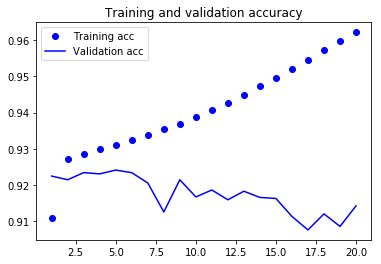

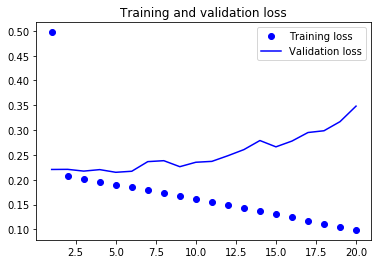

In [13]:
acc = base_history.history['acc']
val_acc = base_history.history['val_acc']
loss = base_history.history['loss']
val_loss = base_history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Save Model

In [16]:
def save_base(model_name):
    model_str = str(input("Save model as: "))

    # serialize model to JSON
    model_name = baseline.to_json()
    with open("CNN Models/" + model_str + ".json", "w") as json_file:
        json_file.write(model_name)

    # serialize weights to HDF5
    baseline.save_weights("CNN Models/" + model_str + ".h5")
    print("Saved " + model_str + " and weights to CNN Models folder")

In [17]:
save_model(base_history)

Save model as: baseline20
Saved baseline20 and weights to CNN Models folder


# Load Model

In [53]:
def load_model():
    model_str = str(input("Name of model to load: "))

    # load json and create model
    json_file = open('CNN Models/' + model_str + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("CNN Models/" + model_str + ".h5")
    print("Loaded " + model_str + " and weights from CNN Models folder")
    
    return loaded_model

# Comparison Model

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(15, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(optimizer = optimizers.RMSprop(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model_4C_4MP_1D = model.fit(training_img, training_labels, epochs = 20, validation_split = (1 / 9), batch_size = 128, verbose = 0)

In [ ]:
model_test = model.evaluate(test_img, test_labels)

In [ ]:
print(model_test)

### Plot Results Compared To Baseline

In [ ]:
base_acc = base_history.history['val_acc']
model_acc = model_4C_4MP_1D.history['val_acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, base_acc, 'b', label='Base Acc')
plt.plot(epochs, model_acc, 'r', label='Model Acc')
plt.title('Comparison of Validation Accuracies')
plt.legend()
plt.show()

In [ ]:
base_loss = base_history.history['val_loss']
model_loss = model_4C_4MP_1D.history['val_loss']
plt.plot(epochs, base_loss, 'b', label='Base loss')
plt.plot(epochs, model_loss, 'r', label='Model loss')
plt.title('Comparison of Validation Losses')
plt.legend()
plt.show()

###### Save model

In [18]:
def save_model(model_name):
    model_str = str(input("Save model as: "))

    # serialize model to JSON
    model_name = model.to_json()
    with open("CNN Models/" + model_str + ".json", "w") as json_file:
        json_file.write(model_name)

    # serialize weights to HDF5
    model.save_weights("CNN Models/" + model_str + ".h5")
    print("Saved " + model_str + " and weights to CNN Models folder")

In [60]:
save_model(model_4C_4MP_1D)

Save model as: model_4C_4MP_1D
Saved model_4C_4MP_1D and weights to CNN Models folder
